## Optical flow control

In a biological study on honeybee landing, [1], Srinivasan et al. showed that honeybees keep optical flow constant while landing. Specifically, they showed that during a grazing landing, the ratio between the honeybees' horizontal speed and their height was a constant for most of the trajectory. We will call this a constant _ventral flow_ landing. Later, robotic studies generalized the idea of constant optical flow landings to straight vertical landings, in which case the _divergence_ in a downward looking camera was kept constant [2,3]. Later, it was shown that honeybees indeed keep the divergence constant during vertical landings [4].

In this notebook, we will look at how easy it is to _control_ a constant optical flow landing. This will illustrate some of the fundamental challenges of using optical flow observables for control.


## Lander model

We will employ an extremely simple lander model as used in [5]. This model only focuses on a single axis, representing a 'drone' that moves only vertically. Below, we will explain this model, using the formulas and figures of [5].

We will use the following state space model:

__Eq. 1__ $\dot{\mathbf{x}}(t) = A \mathbf{x}(t) + B \mathbf{u}(t)$,

where the state vector $\mathbf{x}= [z(t), v_z(t)]^{T}$, and $\mathbf{u}(t) = u_z(t)$, so that:

$\begin{bmatrix} \dot{z}(t) \\ \dot{v_z}(t) \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} z(t) \\ v_z(t) \end{bmatrix} + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u_z(t)$

This model assumes that $u_z$ = $a_z$, implying that any possible gravity is taken care of by the $u_z$-term:
$a_z = -g + \frac{u_z'}{m} = u_z$, where $u_z' = m (a_z + g)$ is the actual upward thrust generated by the robot in Newton. Although [5] goes on to include drag, in this exercise we will leave it out for simplicity.

Below, we see the axis system as used in this exercise. Both the $z$ and $v_z$ axes are positive up. The drone has a downward looking camera. When the drone goes down, it will see an expanding flow field, i.e., with positive divergence $D$. In this exercise, we will not use the divergence itself, but the relative vertical velocity $\vartheta_z = \frac{v_z}{z} = -D$ as the optical flow observable to control. This relative velocity is the negative of divergence and hence is also zero when the drone is not moving and constant when the divergence is constant. 


<CENTER>
<IMG SRC="axes_system.png" WIDTH="300" ALT="Axes system used in the optical flow control exerise."></IMG>
<small>Figure 1 from [5]: Axis system used in the exercise. </small>
</CENTER>

The control law followed by the drone will be also very simple:

$u_z = P_z (\vartheta_z^{*} - \vartheta_z)$.

## Perfect measurements
Let us now see how difficult it is to control a constant divergence landing when the lander perfectly perceives the divergence. We will use functions from the Python script `exercise_landing_python.py`. Specifically, we will simulate the state space model from Eq. 1, where the lander is continuously sensing the relative velocity without any delay (function `f_continuous`). In the controller, the relative velocity is directly set to `(x[1] / x[0])`, i.e., the velocity divided by the height.


C:\Users\guido\Desktop\optic_flow_control_notebook\exercise_landing_python.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  states_over_time[t_index, :] = x;


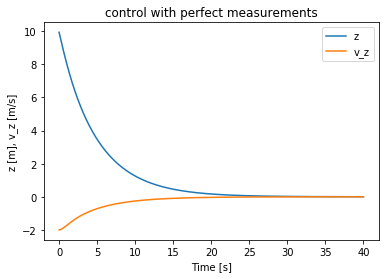

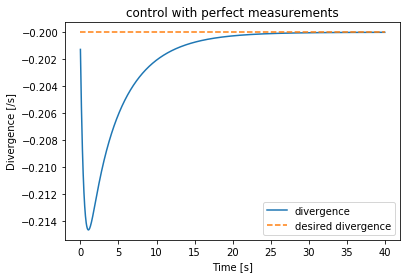

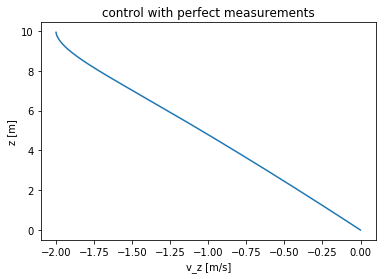

In [1]:
%matplotlib inline
import exercise_landing_python as OFL
import numpy as np

# state x = [height, vertical velocity]
OFL.x0 = [10.0, -2.0]
# desired divergence = the desired (velocity / height)
OFL.desired_div = OFL.x0[1] / OFL.x0[0]; # should not be called div but relvel

OFL.P = 25;
OFL.dt = 0.033;

# global variables:
OFL.n_states = 2;
OFL.t0 = 0;
OFL.t1 = 40;
OFL.time_steps = np.arange(OFL.t0, OFL.t1, OFL.dt);
OFL.n_time_steps = len(OFL.time_steps);

# control with perfect measurements:
states_over_time = OFL.continuous_control();
OFL.plot_states_over_time(states_over_time, OFL.time_steps, plot_title='control with perfect measurements')



## References

[1] M.V. Srinivasan, S.W. Zhang, M. Lehrer, and S. Collett, Honeybee navigation en route to the goal: visual flight control and odometry. The Journal of Experimental Biology 199, 237–244 (1996).

[2] B. Hérissé, T. Hamel, R. Mahony, and F.-X. Russotto. Landing a VTOL Unmanned Aerial  Vehicle on a moving platform using optical  flow. IEEE Transactions on Robotics, 28(1):77–89, 2012.

[3] Izzo, D., and de Croon, G.C.H.E. (2012). Landing with time-to-contact and ventral optic flow estimates. Journal of Guidance, Control, and Dynamics, 35(4), 1362-1367.

[4] E. Baird, N. Boeddeker, M.R. Ibbotson, and M.V. Srinivasan. A universal strategy for visually guided landing. PNAS: Biological Sciences - Neuroscience, 2013.

[5] G.C.H.E. de Croon (2016). Monocular distance estimation with optical flow maneuvers and efference copies: a stability-based strategy. Bioinspiration & biomimetics, 11(1), 016004.
